In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_Br

In [2]:
import nibabel as nib
import nilearn as nl
import nilearn.plotting as nlplt

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import os

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<05:33, 460B/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<11:05, 768B/s] 
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<10:13, 792B/s] 
US1_UNCR.dcm:   0%|          | 226/923k [00:00<11:41, 1.32kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<19:47, 5.17kB/s]


In [3]:
TRAIN_DATASET_PATH = os.path.join(
    '..',
    'input',
    'brats20-dataset-training-validation',
    'BraTS2020_TrainingData',
    'MICCAI_BraTS2020_TrainingData'
)
VALIDATION_DATASET_PATH = os.path.join(
    '..',
    'input',
    'brats20-dataset-training-validation',
    'BraTS2020_ValidationData',
    'MICCAI_BraTS2020_ValidationData'
)

Text(0.5, 1.0, 'seg')

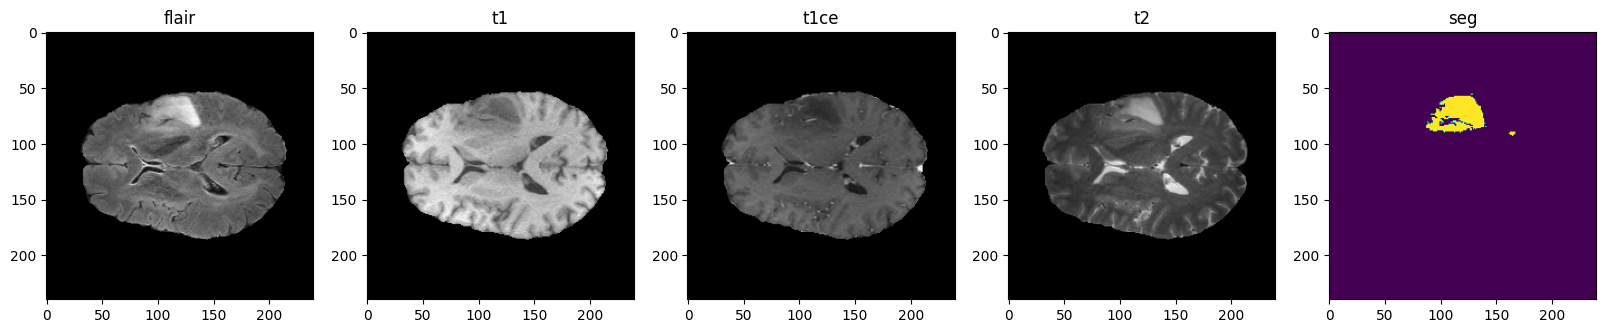

In [4]:
data_name = 'BraTS20_Training_002'

flair = nib.load(
    os.path.join(TRAIN_DATASET_PATH, data_name, f'{data_name}_flair.nii')
).get_fdata()
seg = nib.load(
    os.path.join(TRAIN_DATASET_PATH, data_name, f'{data_name}_seg.nii')
).get_fdata()
t1 = nib.load(
    os.path.join(TRAIN_DATASET_PATH, data_name, f'{data_name}_t1.nii')
).get_fdata()
t1ce = nib.load(
    os.path.join(TRAIN_DATASET_PATH, data_name, f'{data_name}_t1ce.nii')
).get_fdata()
t2 = nib.load(
    os.path.join(TRAIN_DATASET_PATH, data_name, f'{data_name}_t2.nii')
).get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 47
ax1.imshow(flair[:,:,flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('flair')
ax2.imshow(t1[:,:,t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('t1')
ax3.imshow(t1ce[:,:,t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('t1ce')
ax4.imshow(t2[:,:,t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('t2')
ax5.imshow(seg[:,:,seg.shape[0]//2-slice_w])
ax5.set_title('seg')

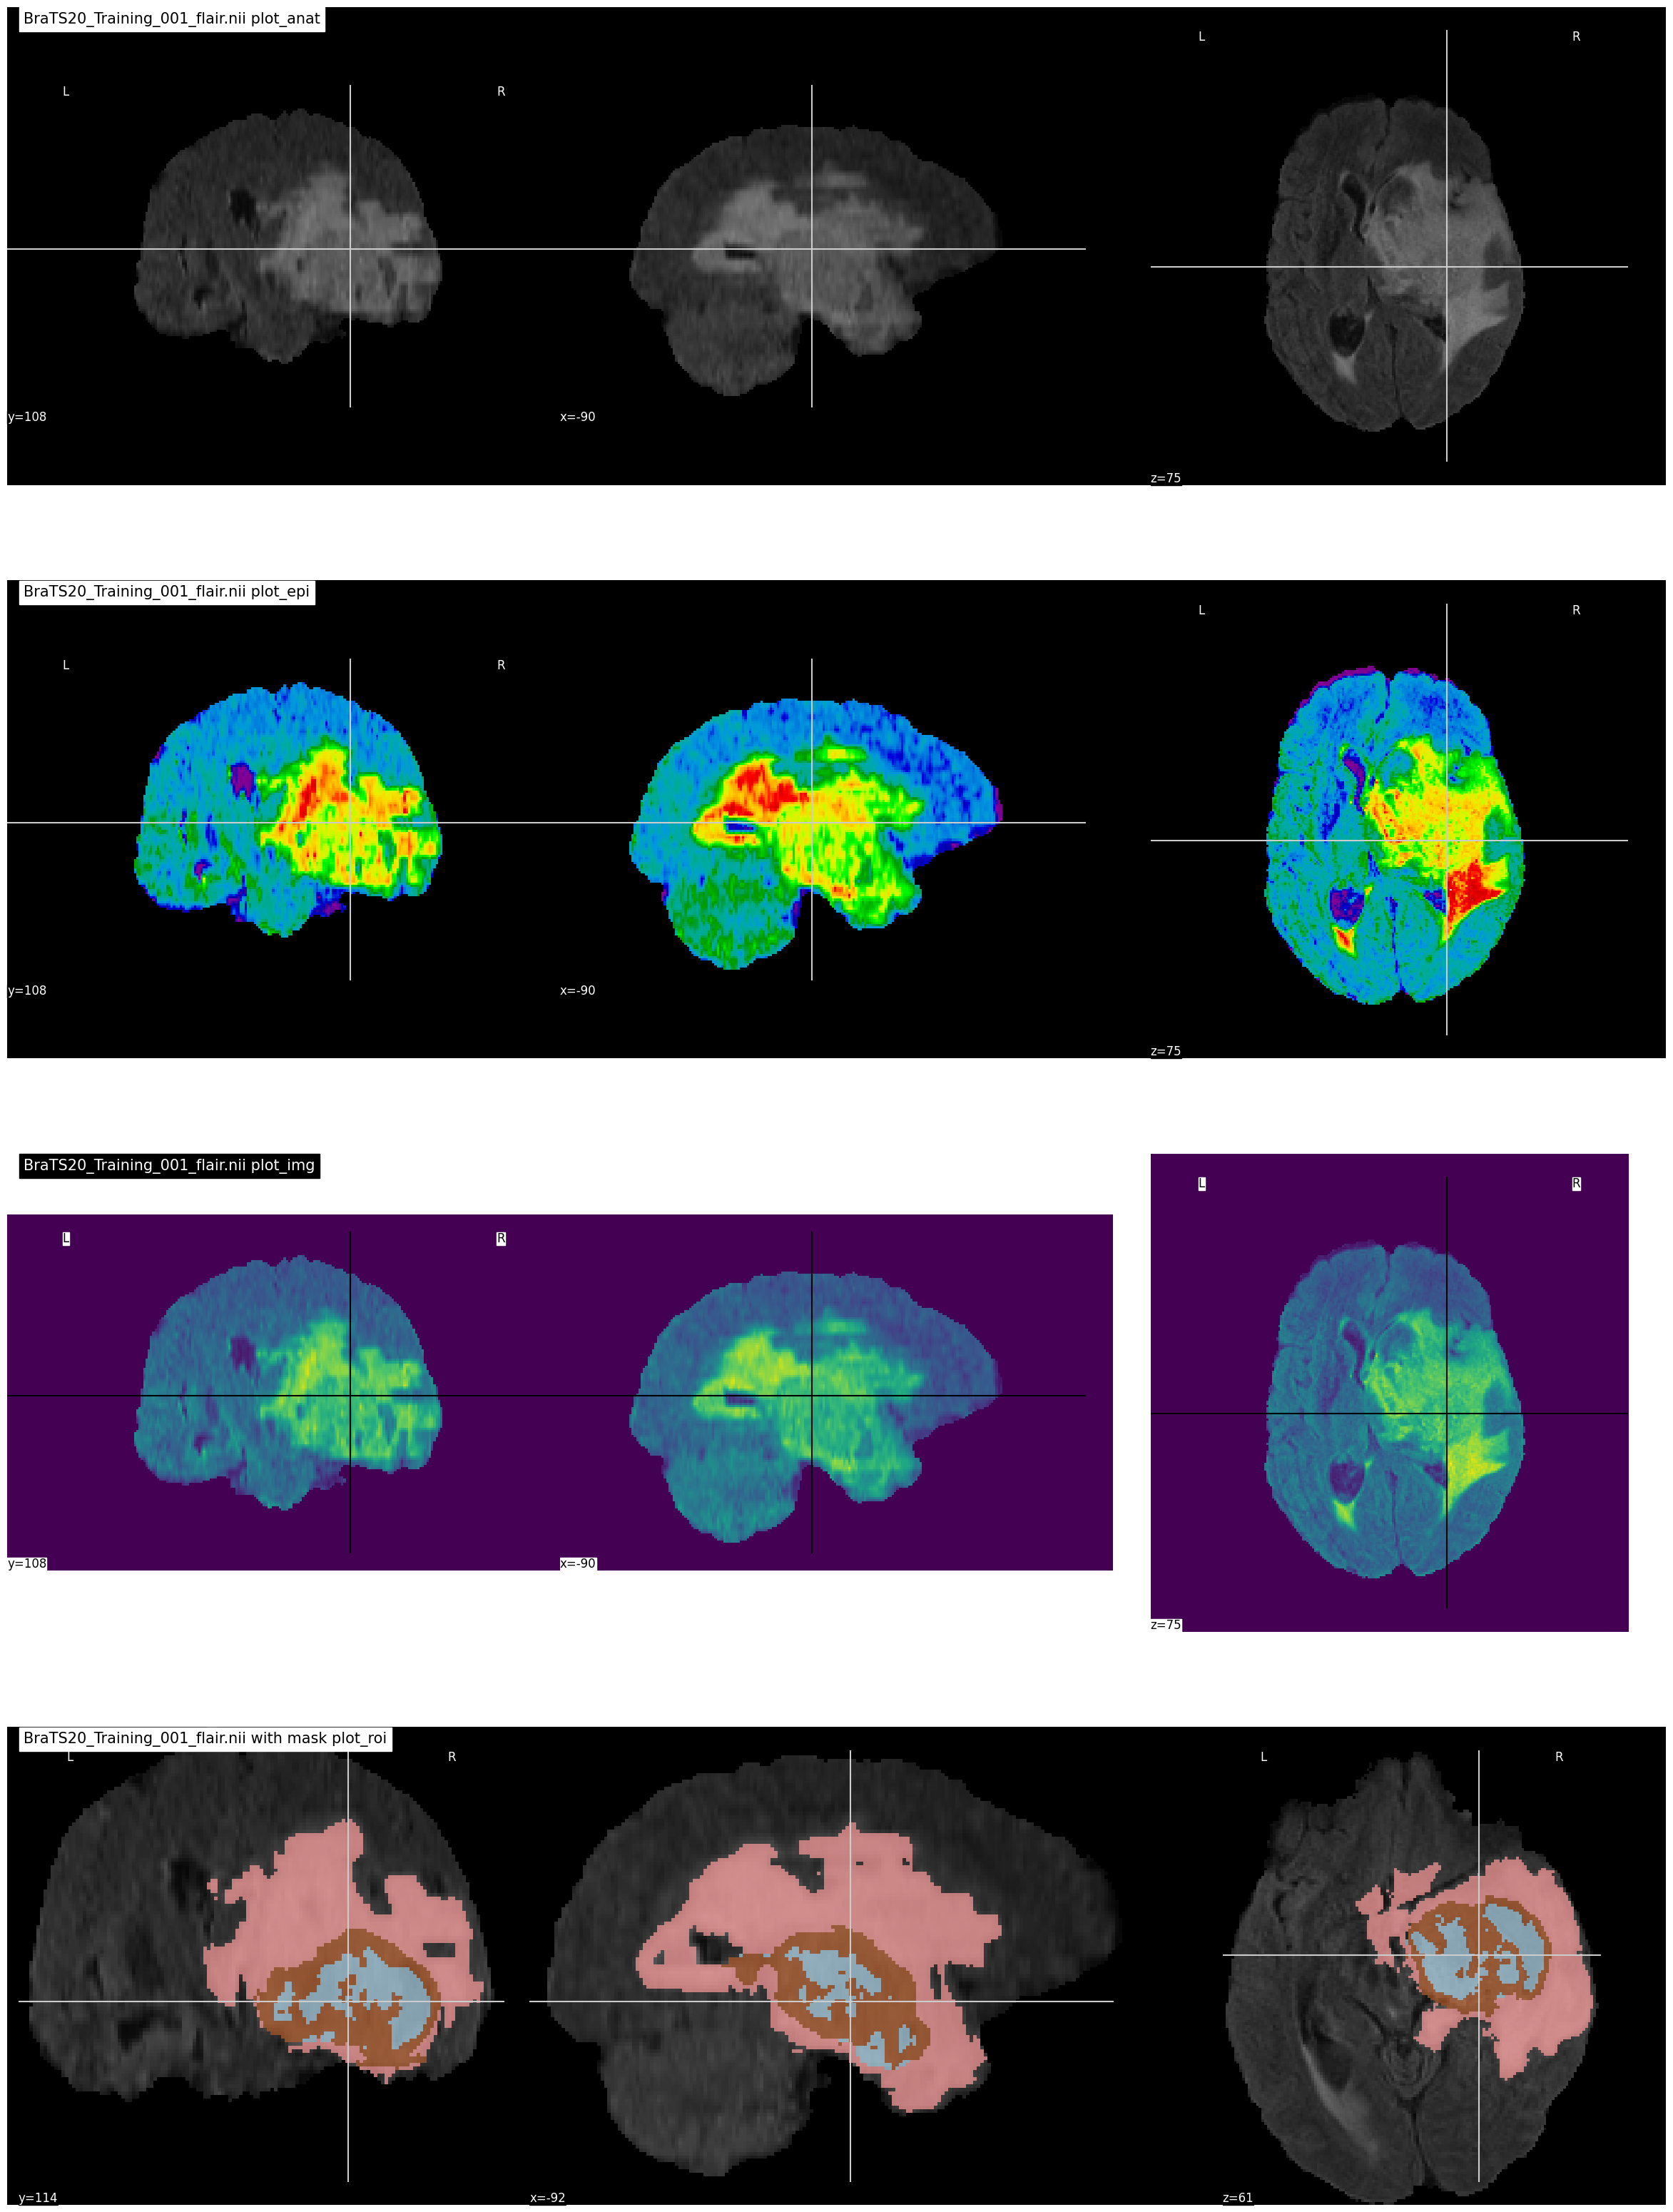

In [5]:
flair_ni = nl.image.load_img(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001/BraTS20_Training_001_flair.nii'))
seg_ni = nl.image.load_img(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001/BraTS20_Training_001_seg.nii'))

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(
    flair_ni,
    title='BraTS20_Training_001_flair.nii plot_anat',
    axes=axes[0]
)

nlplt.plot_epi(
    flair_ni,
    title='BraTS20_Training_001_flair.nii plot_epi',
   axes=axes[1]
)

nlplt.plot_img(
    flair_ni,
    title='BraTS20_Training_001_flair.nii plot_img',
    axes=axes[2]
)

nlplt.plot_roi(
    seg_ni, 
    title='BraTS20_Training_001_flair.nii with mask plot_roi',
    bg_img=flair_ni, 
    axes=axes[3], cmap='Paired'
)

plt.show()

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [7]:
def dice_coef_healthy(y_true, y_pred, epsilon=K.epsilon()):
    intersection = K.sum(K.abs(y_true[:,:,:,0] * y_pred[:,:,:,0]))
    return (2. * intersection + epsilon) / (K.sum(K.square(y_true[:,:,:,0])) + K.sum(K.square(y_pred[:,:,:,0])) + epsilon)

def dice_coef_core(y_true, y_pred, epsilon=K.epsilon()):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection + epsilon) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=K.epsilon()):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection + epsilon) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=K.epsilon()):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection + epsilon) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

def dice_coefficient_multiclass(y_true, y_pred):
    healthy = dice_coef_healthy(y_true, y_pred)
    core = dice_coef_core(y_true, y_pred)
    edema = dice_coef_edema(y_true, y_pred)
    enhancing = dice_coef_enhancing(y_true, y_pred)
    
    return (healthy + core + edema + enhancing) / 4

def combined_loss_multiclass(y_true, y_pred):
    dice_loss = 1 - dice_coefficient_multiclass(y_true, y_pred)
    cross_entropy_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return 0.7 * dice_loss + 0.3 * cross_entropy_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [8]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

In [9]:
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(
    loss = combined_loss_multiclass,
    optimizer = keras.optimizers.Adam(learning_rate=0.001), 
    metrics = [
        'accuracy', 
        dice_coefficient_multiclass,
        dice_coef_healthy,
        dice_coef_core, 
        dice_coef_edema,
        dice_coef_enhancing,
        tf.keras.metrics.MeanIoU(num_classes=4),
        precision, 
        sensitivity, 
        specificity
    ]
)

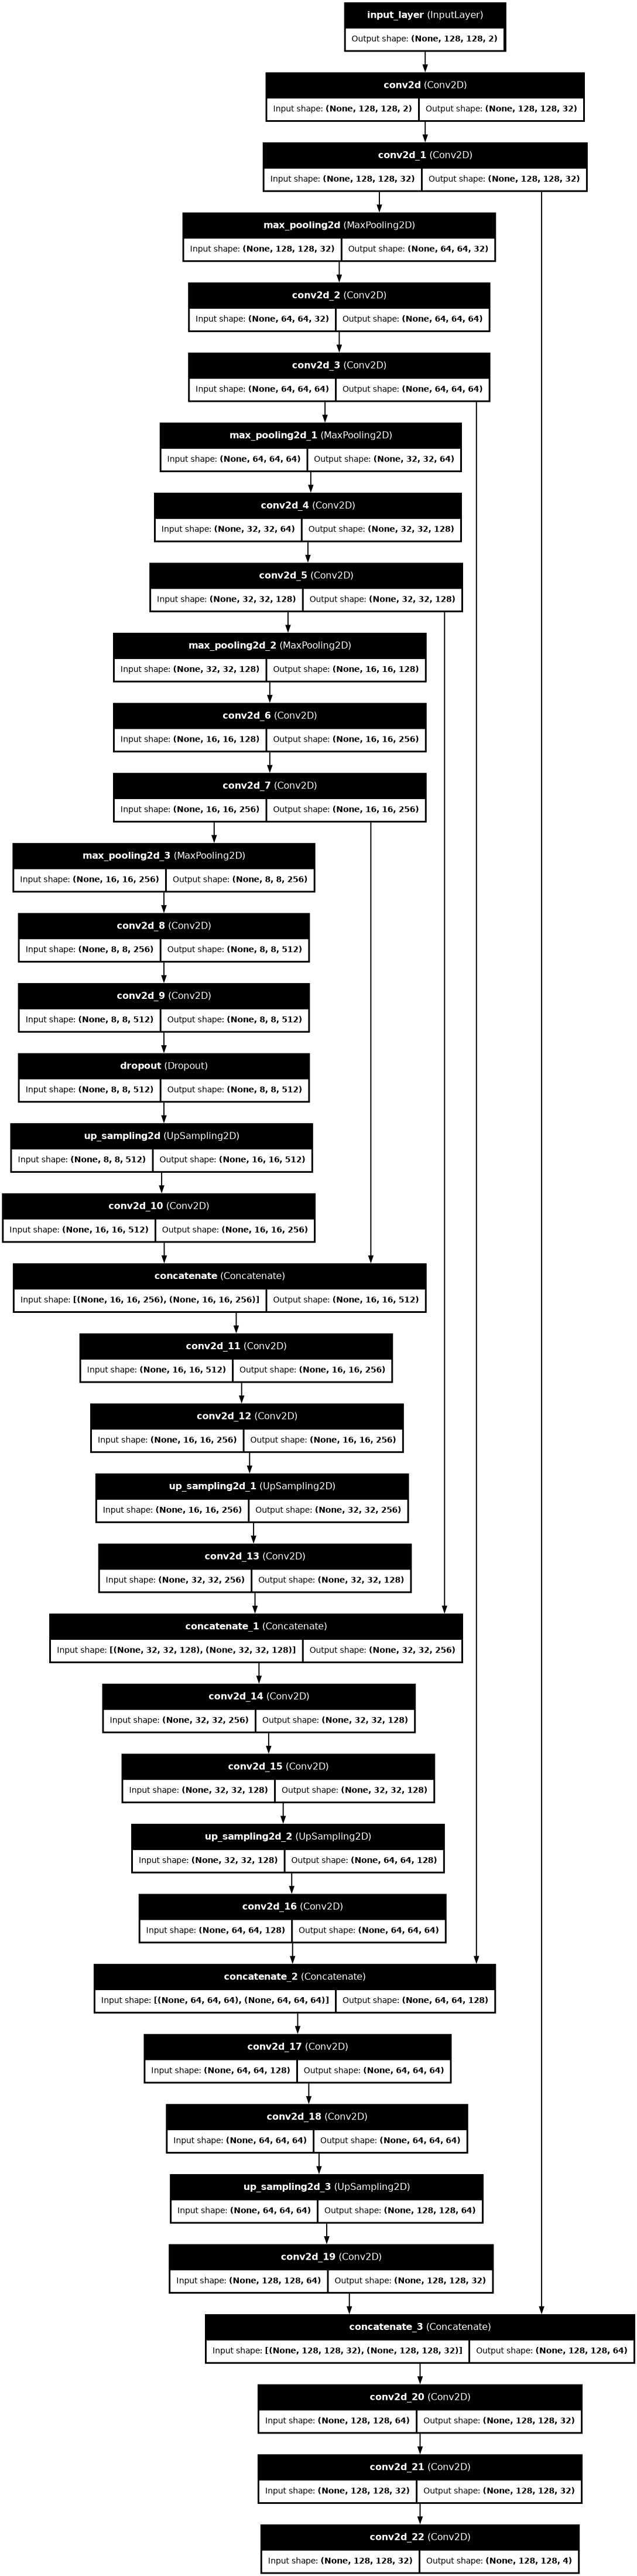

In [10]:
keras.utils.plot_model(
    model, 
    show_shapes = True,
    show_dtype = False,
    show_layer_names = True, 
    rankdir = 'TB', 
    expand_nested = False, 
    dpi = 70
)

In [11]:
train_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# There is a problem in naming of BraTS20_Training_355 so its easier to remove it
train_directories.remove('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355')

def pathListIntoIds(dirList):
    x = []
    for i in range(0, len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_val_ids = pathListIntoIds(train_directories)
train_ids, val_ids = train_test_split(train_val_ids, test_size = 0.2)

In [12]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dataset_path, batch_size = 1, dim=(IMG_SIZE,IMG_SIZE), n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.dataset_path = dataset_path
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(self.dataset_path, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii')
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii')
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j + VOLUME_SLICES * c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j + VOLUME_SLICES * c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j + VOLUME_SLICES * c] = seg[:,:,j + VOLUME_START_AT]
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X / np.max(X), Y

In [14]:
training_generator = DataGenerator(train_ids, TRAIN_DATASET_PATH)
val_generator = DataGenerator(val_ids, TRAIN_DATASET_PATH)

In [15]:
X, Y = training_generator.__getitem__(111)

In [16]:
csv_logger = keras.callbacks.CSVLogger('training.log', separator=',', append=False)

callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.000001,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = 'checkpoints/model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
        verbose=1,
        save_weights_only = True
    ),
    csv_logger
]

In [17]:
keras.backend.clear_session()

history =  model.fit(
    training_generator,
    epochs = 25,
    steps_per_epoch = len(train_ids),
    callbacks = callbacks,
    validation_data = val_generator
)  
model.save("3D_MRI_Brain_tumor_segmentation.keras")

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727768400.241537     276 service.cc:145] XLA service 0x7a7844003350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727768400.241600     276 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727768429.487386     276 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9373 - dice_coef_core: 0.0811 - dice_coef_edema: 0.1757 - dice_coef_enhancing: 0.0808 - dice_coef_healthy: 0.9558 - dice_coefficient_multiclass: 0.3234 - loss: 0.5484 - mean_io_u: 0.4817 - precision: 0.9485 - sensitivity: 0.8937 - specificity: 0.9960
Epoch 1: saving model to checkpoints/model_.01-0.461654.weights.h5
294/294 ━━━━━━━━━━━━━━━━━━━━ 277s 799ms/step - accuracy: 0.9374 - dice_coef_core: 0.0813 - dice_coef_edema: 0.1759 - dice_coef_enhancing: 0.0810 - dice_coef_healthy: 0.9559 - dice_coefficient_multiclass: 0.3235 - loss: 0.5482 - mean_io_u: 0.4817 - precision: 0.9486 - sensitivity: 0.8938 - specificity: 0.9960 - val_accuracy: 0.9482 - val_dice_coef_core: 0.1745 - val_dice_coef_edema: 0.3248 - val_dice_coef_enhancing: 0.0981 - val_dice_coef_healthy: 0.9817 - val_dice_coefficient_multiclass: 0.3948 - val_loss: 0.4617 - val_mean_io_u: 0.2501 - val_precision: 0.9695 - val_sensitivity: 0.9423 - val_specificity: 0.9901 - lear

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to checkpoints/model_.02-0.461654.weights.h5
294/294 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.0000e+00 - dice_coef_core: 0.0000e+00 - dice_coef_edema: 0.0000e+00 - dice_coef_enhancing: 0.0000e+00 - dice_coef_healthy: 0.0000e+00 - dice_coefficient_multiclass: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9482 - val_dice_coef_core: 0.1745 - val_dice_coef_edema: 0.3248 - val_dice_coef_enhancing: 0.0981 - val_dice_coef_healthy: 0.9817 - val_dice_coefficient_multiclass: 0.3948 - val_loss: 0.4617 - val_mean_io_u: 0.2501 - val_precision: 0.9695 - val_sensitivity: 0.9423 - val_specificity: 0.9901 - learning_rate: 0.0010
Epoch 3/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9526 - dice_coef_core: 0.1673 - dice_coef_edema: 0.2736 - dice_coef_enhancing: 0.2267 - dice_coef_healthy: 0.9815 - dice_coefficient_multiclass: 0.4123 - loss: 0.4468 - mean_io_u:

In [17]:
import tensorflow as tf
from keras.optimizers import Adam
import numpy as np
import nibabel as nib
import cv2

# Load the saved model
model = tf.keras.models.load_model("3D_MRI_Brain_tumor_segmentation.keras", custom_objects = {
    'combined_loss_multiclass': combined_loss_multiclass,
    'dice_coefficient_multiclass': dice_coefficient_multiclass,
    'precision': precision,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'dice_coef_healthy': dice_coef_healthy,
    'dice_coef_core': dice_coef_core,
    'dice_coef_edema': dice_coef_edema,
    'dice_coef_enhancing': dice_coef_enhancing,
    'Adam': Adam
})

In [18]:
def preprocess_image(image_file, slice_index=None):
    img = nib.load(image_file).get_fdata()
    
    if slice_index is not None:
        img = img[:, :, slice_index]
    
    # Resize the image to (IMG_SIZE, IMG_SIZE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Normalize the image
    img_resized = img_resized / np.max(img_resized)
    
    return img_resized

def predict(image_paths, slice_index):
    X = np.zeros((1, IMG_SIZE, IMG_SIZE, 2))
    
    # Process specific slices from the images
    X[0, :, :, 0] = preprocess_image(image_paths[0], slice_index)
    X[0, :, :, 1] = preprocess_image(image_paths[1], slice_index)
    
    # Make prediction
    pred = model.predict(X)
    
    return np.argmax(pred[0], axis=-1)

# Example usage
image_paths = [
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_flair.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_t1ce.nii'
]

slice_index = 75  # Example slice index
prediction = predict(image_paths, slice_index)

I0000 00:00:1727771286.732405      95 service.cc:145] XLA service 0x7c81bc00e800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727771286.732463      95 service.cc:153]   StreamExecutor device (0): Host, Default Version


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1727771287.534323      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [19]:
import numpy as np

def get_classification(pred):
    # Get the class with the highest probability for each pixel
    class_predictions = np.argmax(pred, axis=-1)
    return class_predictions

In [20]:
get_classification(prediction)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 56,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 37, 37, 35, 33, 33, 41, 41, 40, 39, 40, 40,
        0, 71, 92, 88, 86, 85, 84, 84, 84, 84, 84, 79, 79, 78, 78, 78, 78,
       78, 78, 78, 78, 80, 82, 75, 76, 76, 92,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [21]:
import matplotlib.pyplot as plt

def visualize_prediction(prediction):
    plt.imshow(prediction, cmap='nipy_spectral')  # 'nipy_spectral' gives distinct colors for different classes
    plt.title('Predicted Segmentation')
    plt.colorbar()
    plt.show()

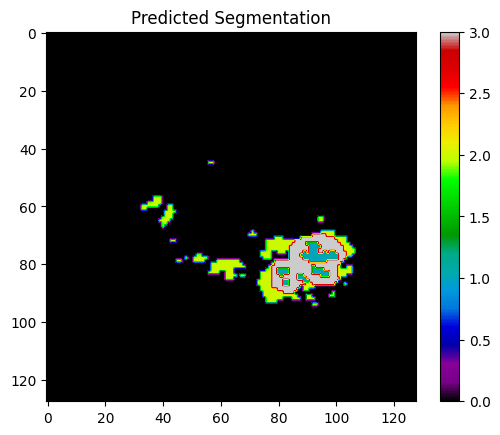

In [22]:
visualize_prediction(prediction)

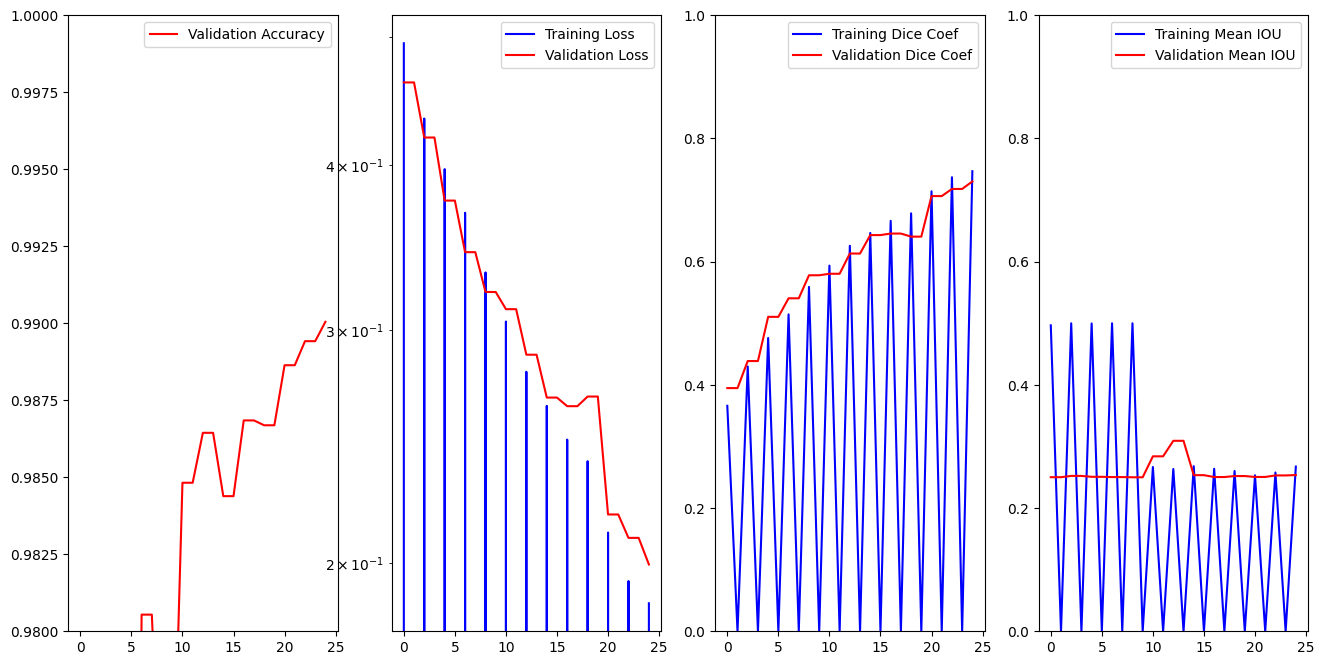

In [24]:
hist = pd.read_csv('training.log', sep=',', engine='python')

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coefficient_multiclass']
val_dice=hist['val_dice_coefficient_multiclass']

f, ax = plt.subplots(1, 4, figsize=(16, 8))

ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()
ax[0].set_ylim(0.98, 1)  # Set y-axis limits for accuracy

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()
ax[1].set_yscale('log')  # Set log scale for y-axis (loss)

ax[2].plot(epoch, train_dice, 'b', label='Training Dice Coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation Dice Coef')
ax[2].legend()
ax[2].set_ylim(0, 1)  # Set y-axis limits for Dice Coefficient

ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training Mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation Mean IOU')
ax[3].legend()
ax[3].set_ylim(0, 1)  # Set y-axis limits for Mean IOU

plt.show()

In [25]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


<Figure size 1800x5000 with 0 Axes>

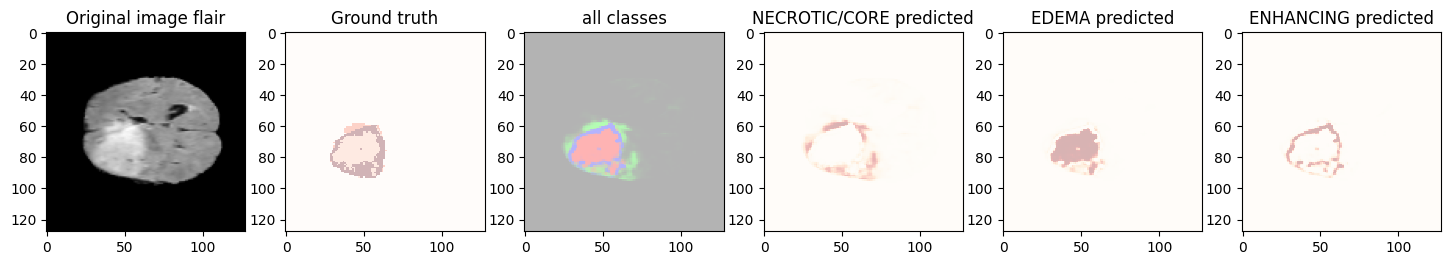

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


<Figure size 1800x5000 with 0 Axes>

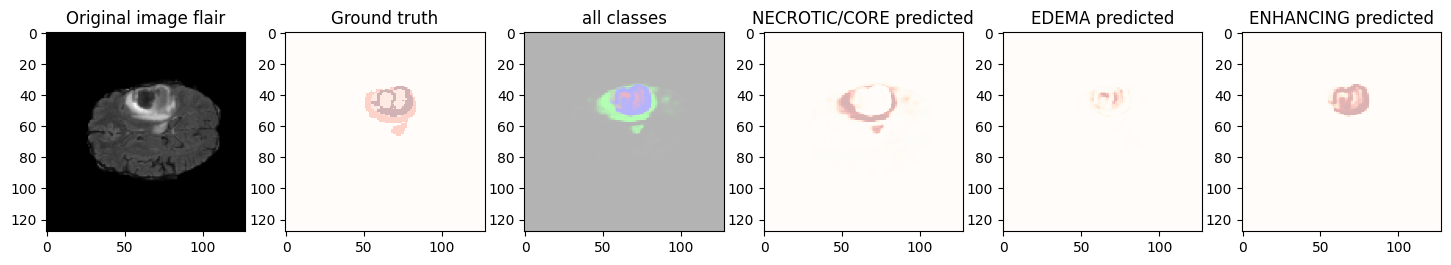

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


<Figure size 1800x5000 with 0 Axes>

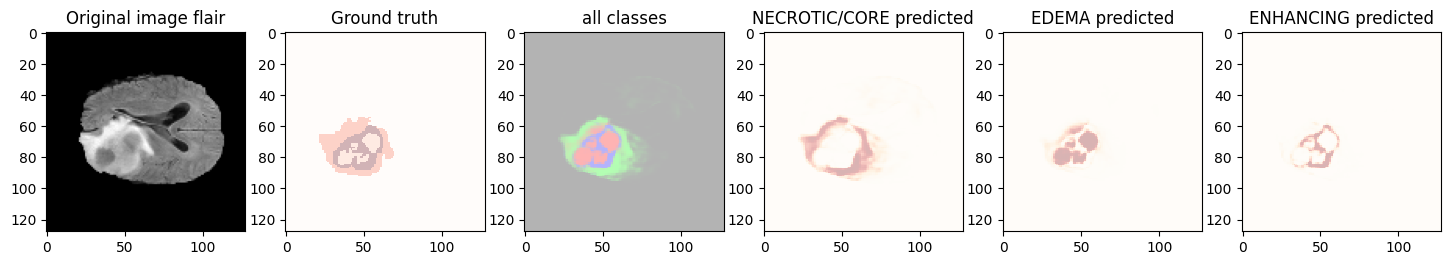

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


<Figure size 1800x5000 with 0 Axes>

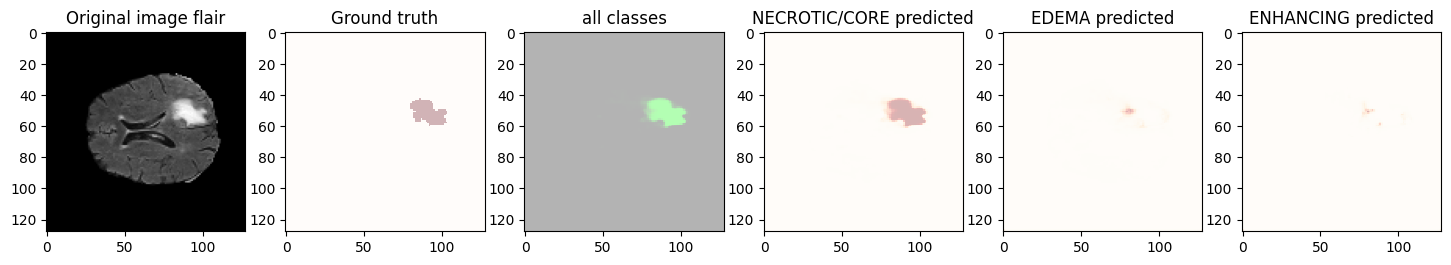

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


<Figure size 1800x5000 with 0 Axes>

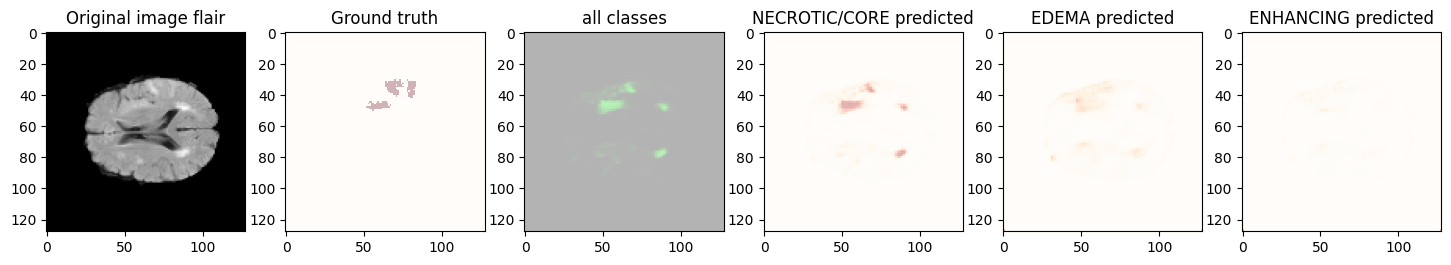

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


<Figure size 1800x5000 with 0 Axes>

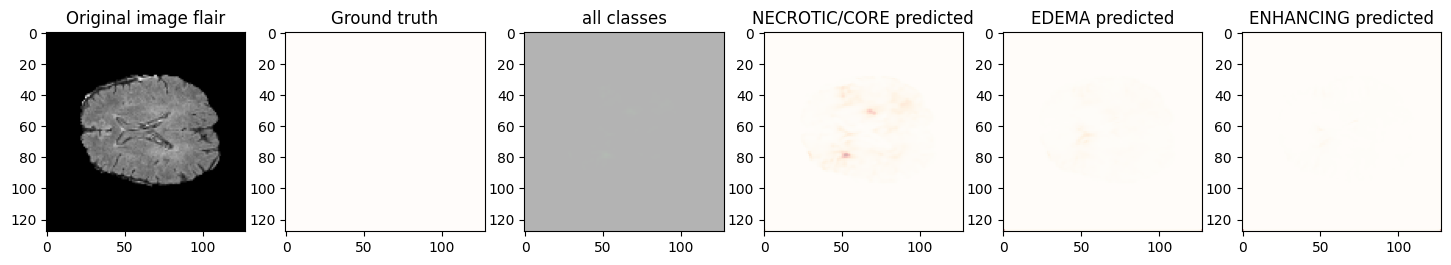

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


<Figure size 1800x5000 with 0 Axes>

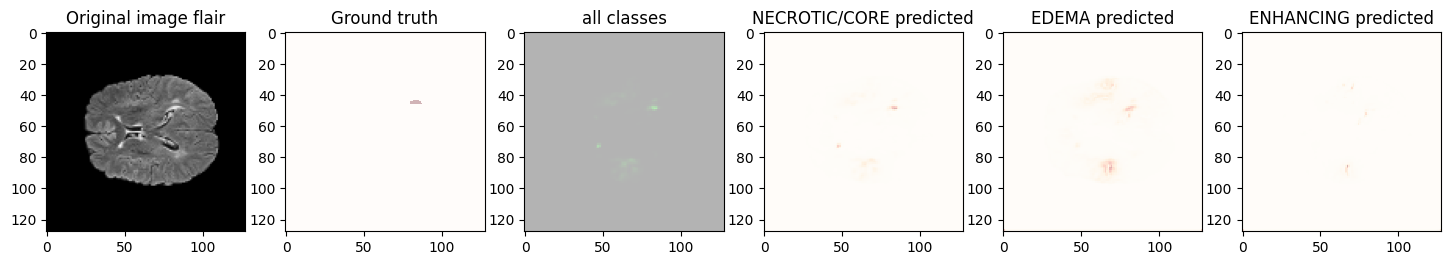

In [26]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce = nib.load(vol_path).get_fdata() 
    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)



def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

#     for i in range(6): # for each image, add brain background
#         axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=val_ids[0][-3:])
showPredictsById(case=val_ids[1][-3:])
showPredictsById(case=val_ids[2][-3:])
showPredictsById(case=val_ids[3][-3:])
showPredictsById(case=val_ids[4][-3:])
showPredictsById(case=val_ids[5][-3:])
showPredictsById(case=val_ids[6][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


<Figure size 640x480 with 0 Axes>

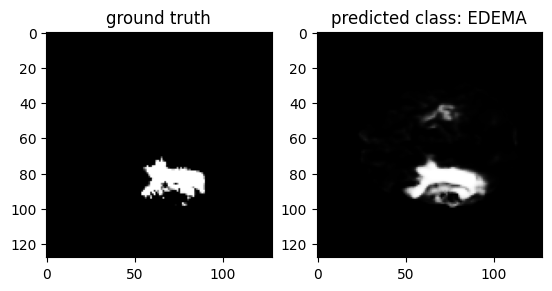

In [29]:
case = val_ids[30][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

i=40
eval_class = 2

gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
import io

mri_data = p.copy()
gif_filename = 'mri_3d.gif'
frames = []

for i in range(mri_data.shape[0]):
    plt.imshow(mri_data[i, :, :, 2], cmap='gray')
    plt.axis('off')
    
    # Save frame to memory
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    frames.append(imageio.imread(buf))
    
    plt.clf()  # Clear figure instead of closing

imageio.mimsave(gif_filename, frames, duration=0.1)
print(f"GIF saved as {gif_filename}")